# Stylized Facts of Asset Returns

**Goal:** Briefly describe the stylized facts of (daily) asset returns and verify their existence using real-life data.

**Introduction:** Stylized facts are, generally speaking, statistical properties that appear to be present in many
empirical asset returns (across time and markets). It is important to be aware of them, because when we are building models that are supposed to represent asset price dynamics, the models must be able to capture/replicate these properties.

**Suggested readings:**
* Empirical properties of asset returns: stylized facts and statistical issues -  https://www.lpsm.paris/pageperso/ramacont/papers/empirical.pdf
* https://orfe.princeton.edu/~jqfan/fan/FinEcon/chap1.pdf
* a great overview of simple vs. log returns - https://www.portfolioprobe.com/2010/10/04/a-tale-of-two-returns/

The script is described in the following article: https://medium.com/@eryk.lewinson/introduction-to-quantitative-finance-stylised-facts-of-asset-returns-6e8e46550665

## Libraries and settings

In [10]:
# libraries ----
import pandas as pd 
import numpy as np
import quandl
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import datetime as dt 

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib')


# settings ----
%config InlineBackend.figure_format ='retina'
%matplotlib inline
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (10.0, 6.0)
sns.mpl.rcParams['savefig.dpi'] = 90
sns.mpl.rcParams['font.size'] = 14

# authentication ----
quandl_key = 'XXX' # paste your own API key here :)
quandl.ApiConfig.api_key = quandl_key

## Data gathering and preparation

In [11]:
# downloading the data 
df = quandl.get('WIKI/MSFT', start_date="2000-01-01", end_date="2017-12-31")
df = df.loc[:, ['Adj. Close']]
df.columns = ['adj_close']

# create simple and log returns, multiplied by 100 for convenience
df['simple_rtn'] = df.adj_close.pct_change()
df['log_rtn'] = (np.log(df.adj_close) - np.log(df.adj_close.shift(1)))

# dropping NA's in the first row
df.dropna(how = 'any', inplace = True)

df.head()

,adj_close,simple_rtn,log_rtn
Date,,,
2000-01-04,37.485073,-0.033802,-0.034387
2000-01-05,37.881159,0.010567,0.010511
2000-01-06,36.613017,-0.033477,-0.034050
2000-01-07,37.092315,0.013091,0.013006
2000-01-10,37.361920,0.007268,0.007242


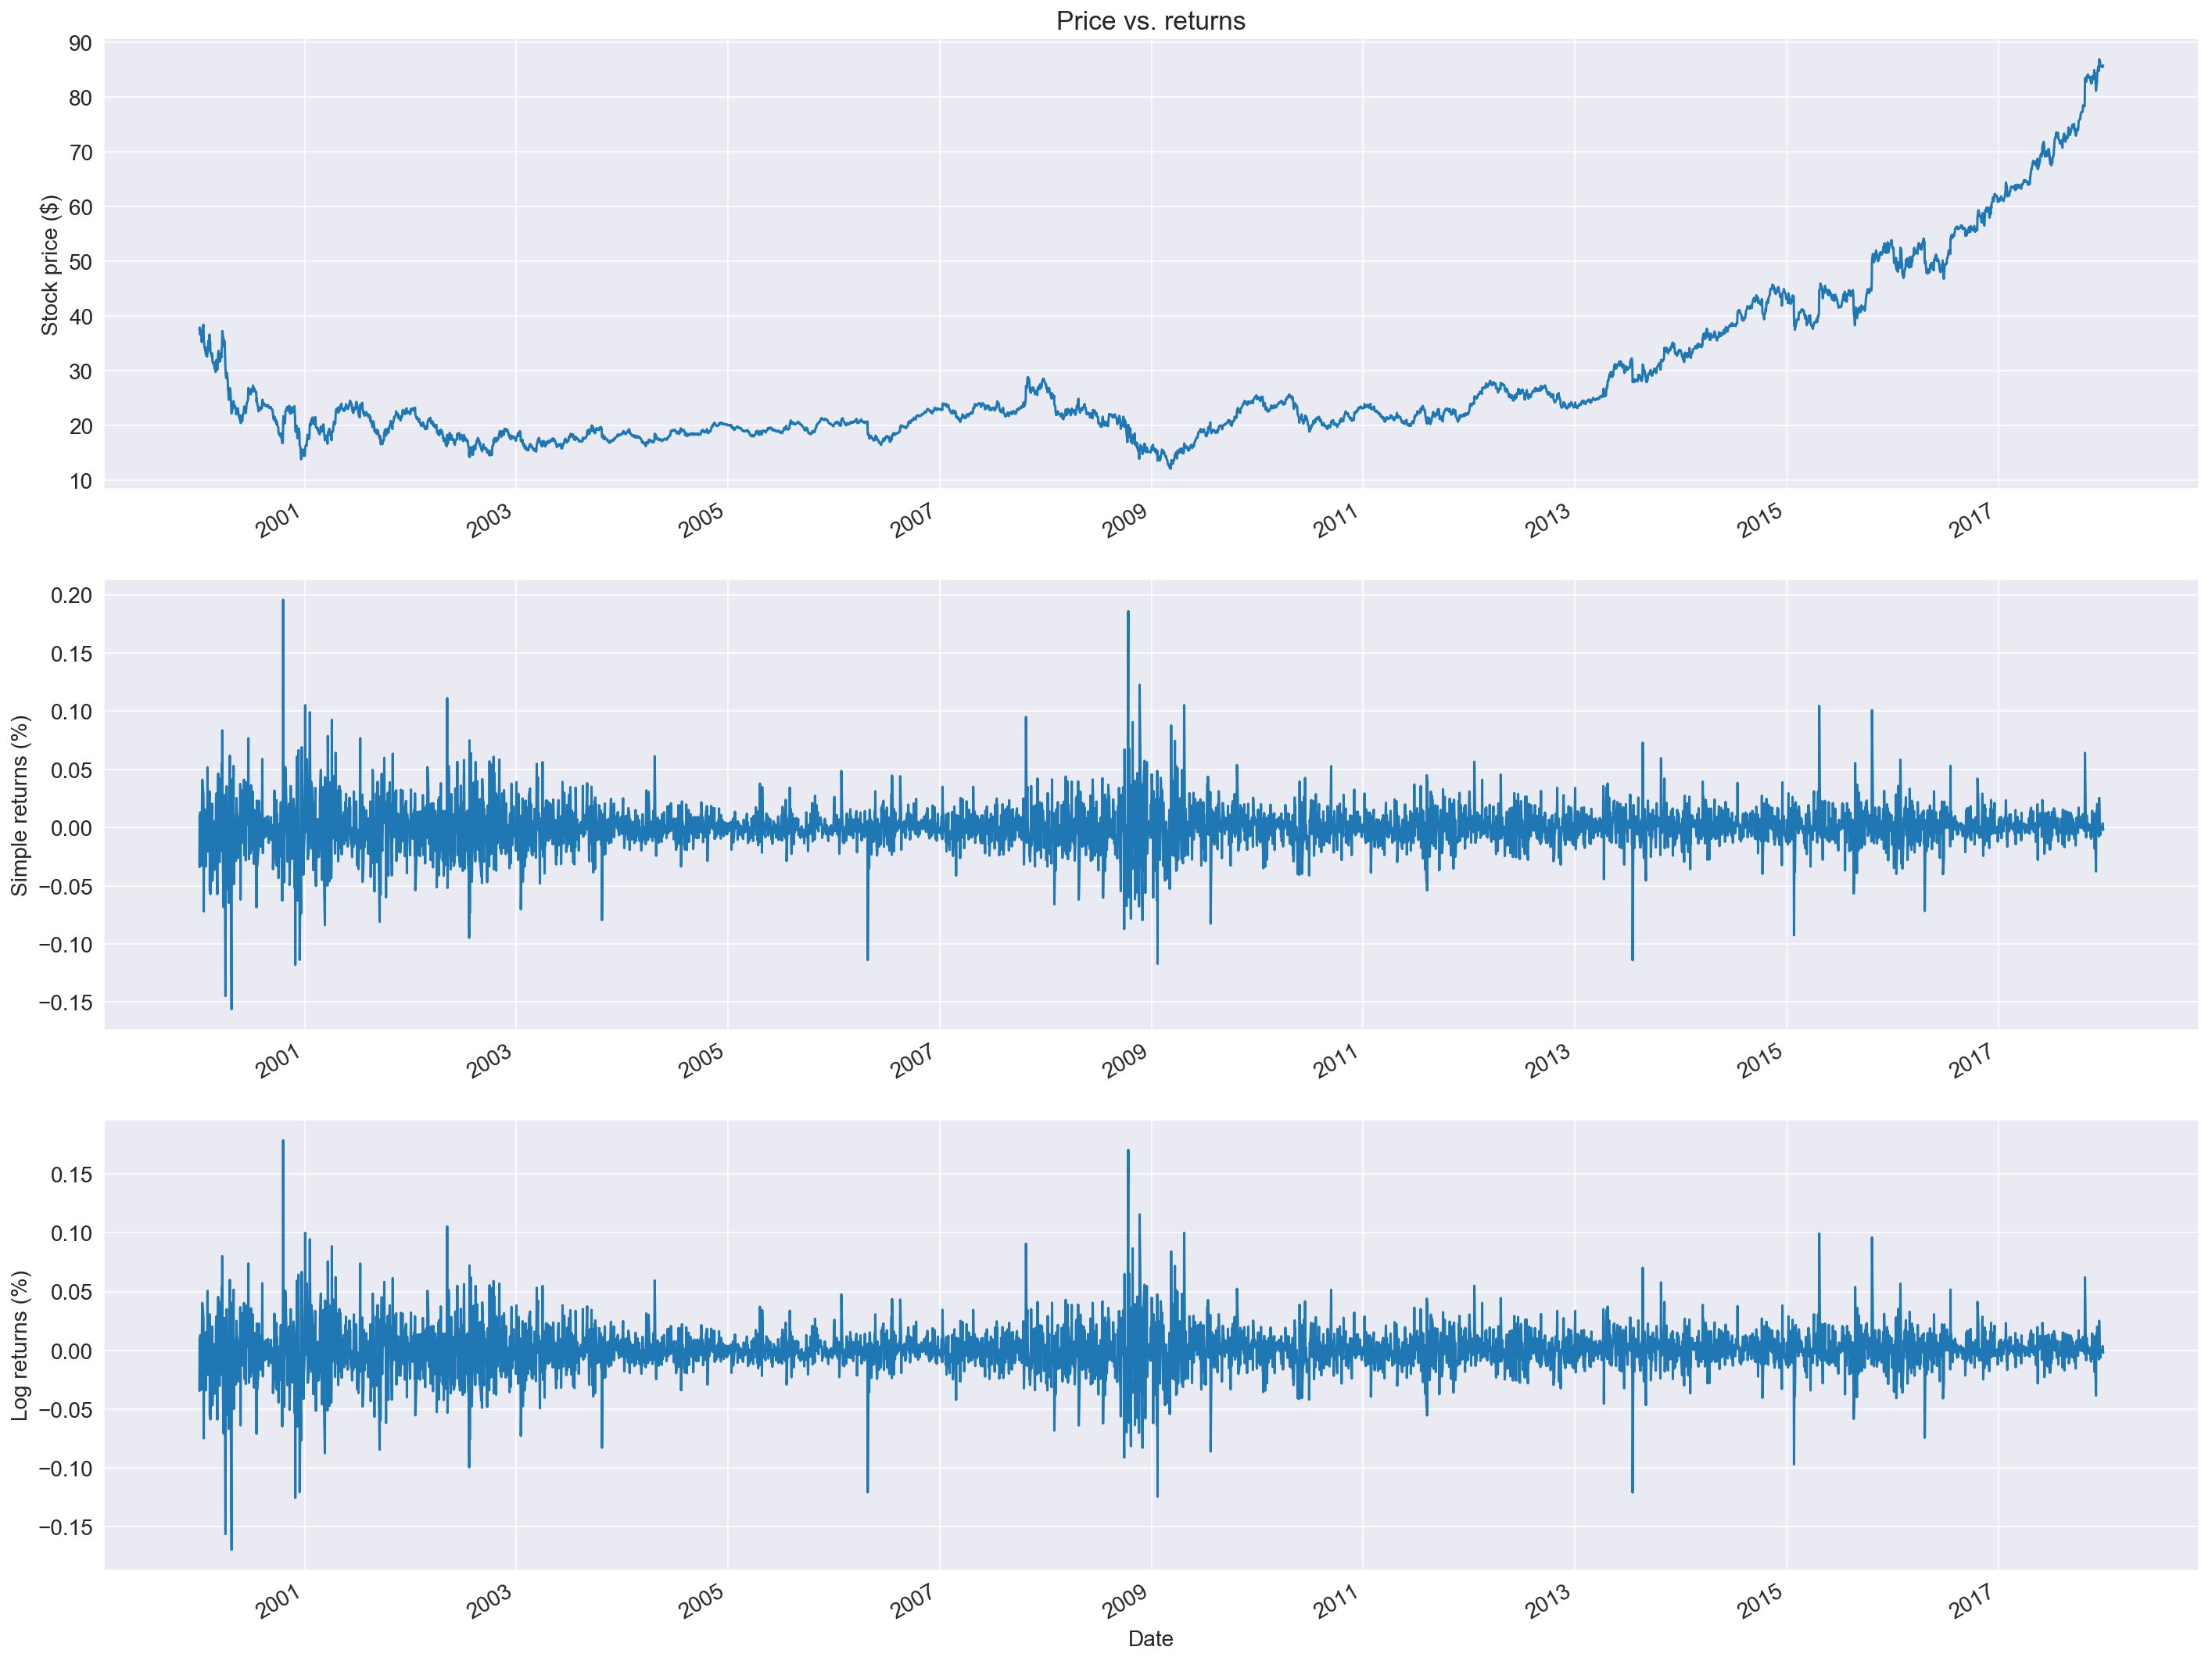

In [12]:
# Plotting the time series ----
fig, ax =plt.subplots(3, 1, figsize=(24, 20))
# price ----
df.adj_close.plot(ax=ax[0])
ax[0].set_ylabel('Stock price ($)')
ax[0].set_xlabel('')
ax[0].set_title('Price vs. returns')
# simple returns ----
df.simple_rtn.plot(ax=ax[1])
ax[1].set_ylabel('Simple returns (%)')
ax[1].set_xlabel('')
# log returns ----
df.log_rtn.plot(ax=ax[2])
ax[2].set_ylabel('Log returns (%)')
fig.show()

## Stylized Facts of Stock Returns

### Distribution of returns is not normal

Returns exhibit:
* negative skewness (third moment) - large negative returns occur more often than large positive ones. Visually: The left tail is longer; the mass of the distribution is concentrated on the right side of the distribution plot.
* excess kurtosis (fourth moment) - large (and small) returns occur more often than expected. Visually: fat-tailed and peaked distribution.

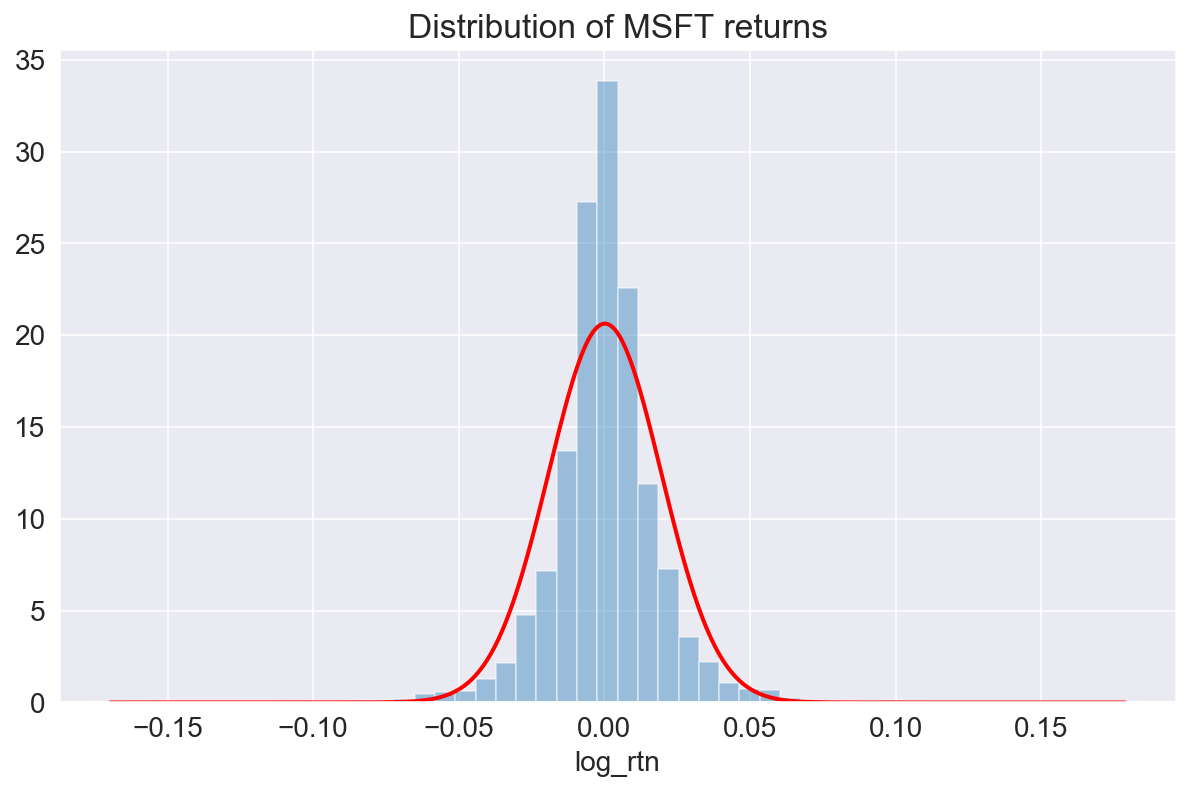

In [13]:
# Plotting the distribution of the returns ----
ax = sns.distplot(df.log_rtn, kde = False, norm_hist=True)                                    

xx = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)                                                  
yy = scs.norm.pdf(xx, loc=df.log_rtn.mean(), scale=df.log_rtn.std())                                                         
ax.plot(xx, yy, 'r', lw=2)
ax.set_title('Distribution of MSFT returns')

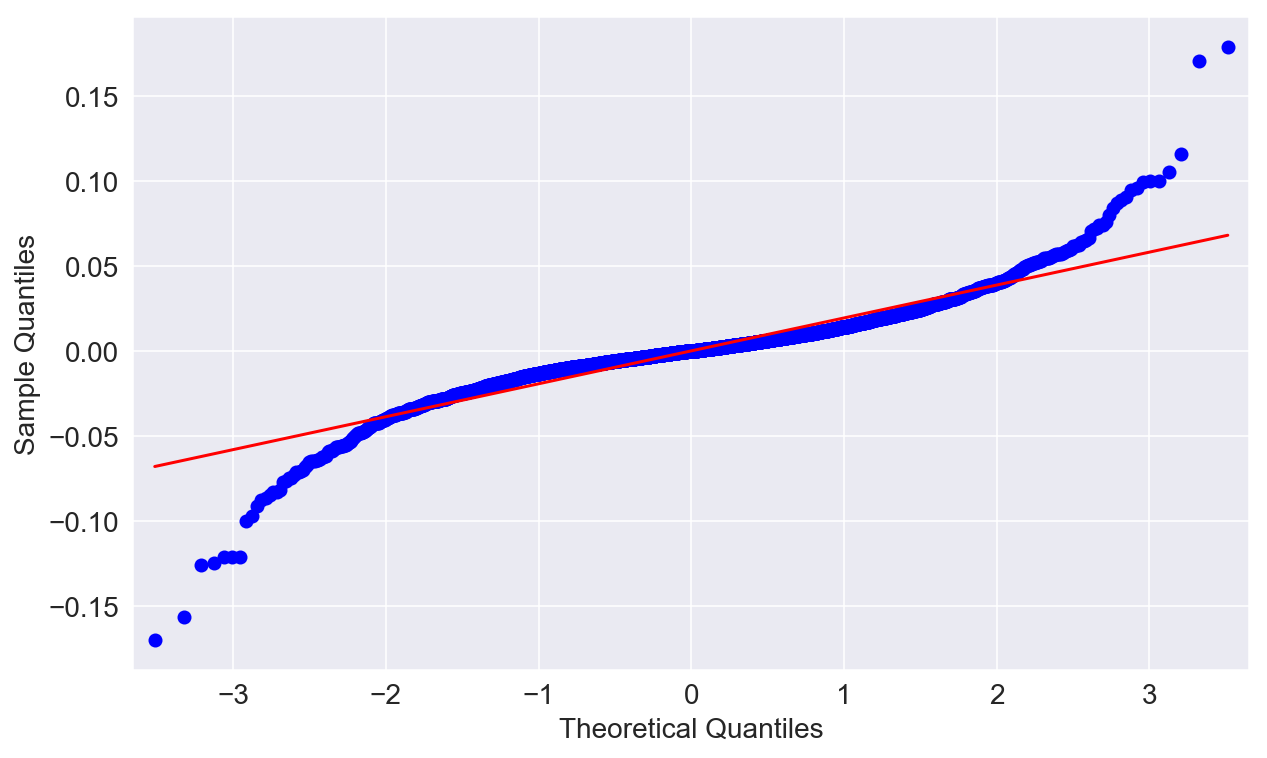

In [14]:
# QQ plot ----
qq = sm.qqplot(df.log_rtn.values, line='s')
qq.show()

In [15]:
# Descriptive statistics ----
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print('Mean: {0:.4f}'.format(df.log_rtn.mean()))
print('Median: {0:.4f}'.format(df.log_rtn.median()))
print('Min: {0:.4f}'.format(df.log_rtn.min()))
print('Max: {0:.4f}'.format(df.log_rtn.max()))
print('Standard Deviation: {0:.4f}'.format(df.log_rtn.std()))
print('Skewness: {0:.4f}'.format(df.log_rtn.skew()))
print('Kurtosis: {0:.4f}'.format(df.log_rtn.kurtosis())) #Kurtosis of std. Normal dist = 0
print('Jarque-Bera statistic: {stat:.2f} with p-value: {p_val:.2f}'.format(stat = scs.jarque_bera(df.log_rtn.values)[0],
                                                                           p_val = scs.jarque_bera(df.log_rtn.values)[1]))

Range of dates: 2000-01-04 - 2017-12-29
Number of observations: 4526
Mean: 0.0002
Median: 0.0000
Min: -0.1697
Max: 0.1788
Standard Deviation: 0.0193
Skewness: -0.1239
Kurtosis: 9.9657
Jarque-Bera statistic: 18694.53 with p-value: 0.00


### No (or almost no) significant autocorrelation in returns

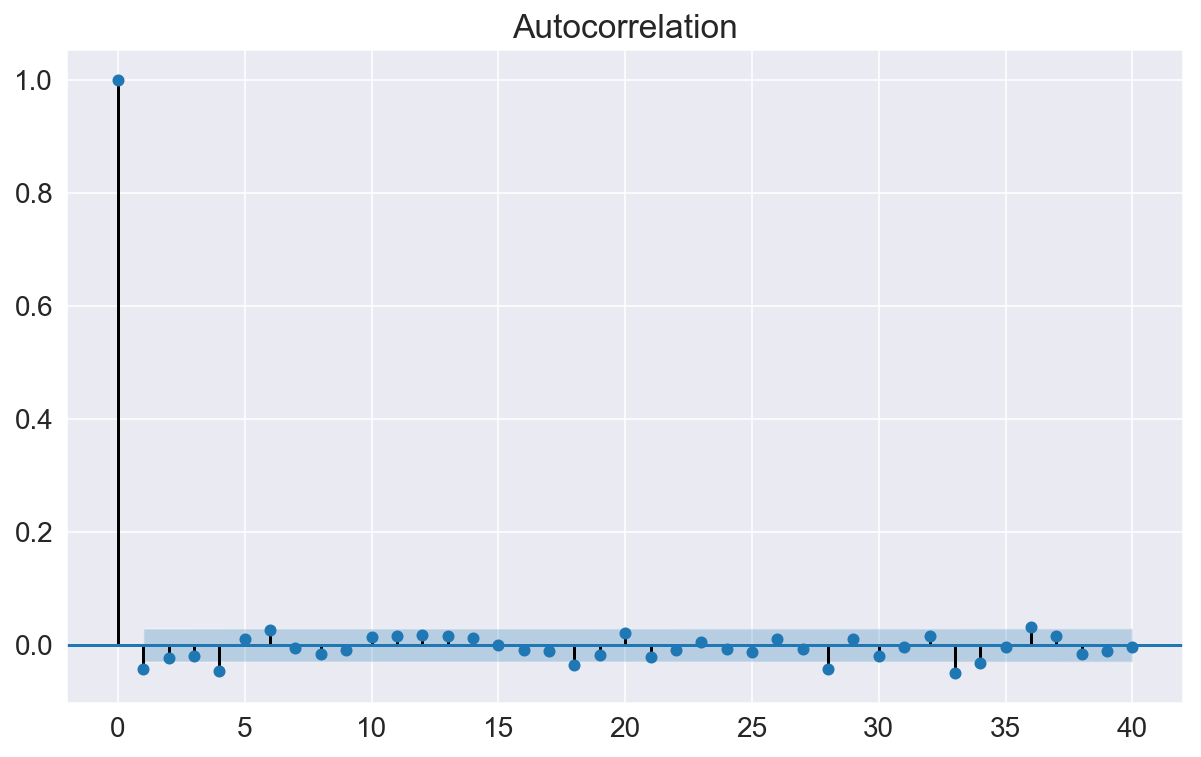

In [16]:
# Autocorrelation plot of log returns ----
acf_r = smt.graphics.plot_acf(df.log_rtn, lags=40 , alpha=0.05)
acf_r.show()

### Small and very slowly declining autocorrelation in squared and absolute returns

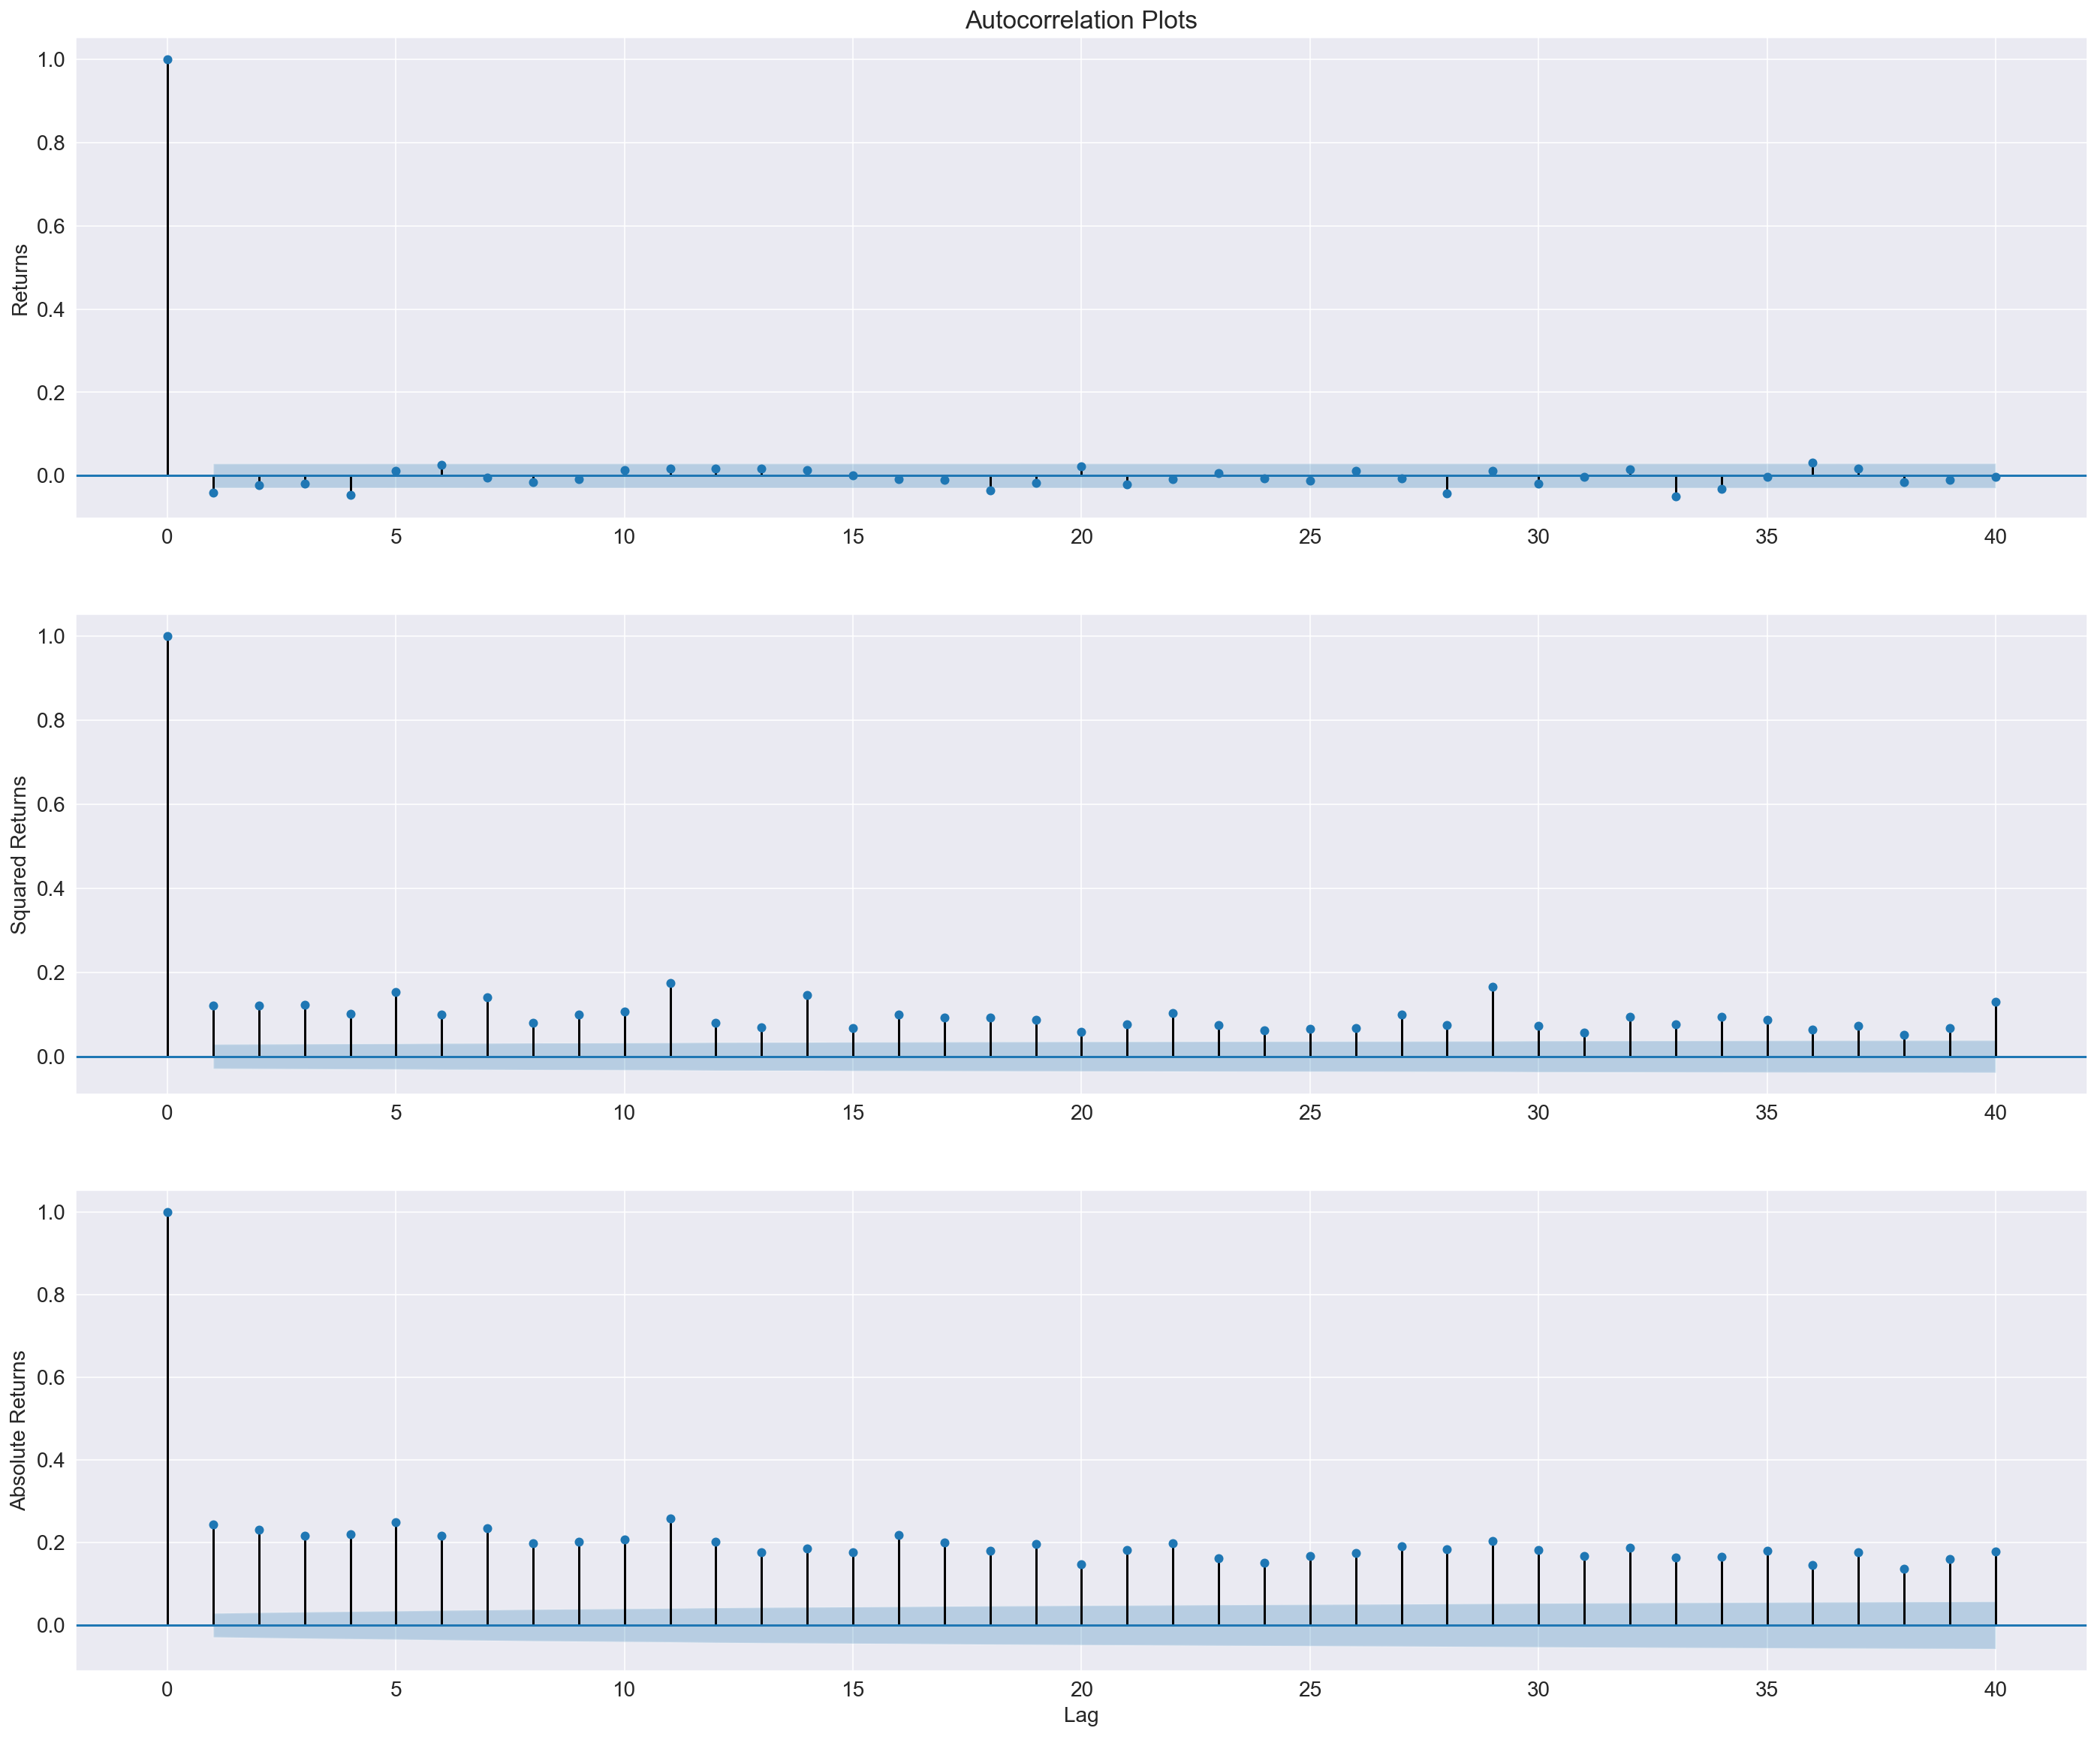

In [17]:
# Autocorrelation plot of log returns and squared/absolute versions ----

# specify the max amount of lags
lags = 40

fig, ax =plt.subplots(3, 1, figsize=(24, 20))
# returns ----
smt.graphics.plot_acf(df.log_rtn, lags=lags , alpha=0.05, ax = ax[0])
ax[0].set_ylabel('Returns')
ax[0].set_title('Autocorrelation Plots')
# squared returns ----
smt.graphics.plot_acf(df.log_rtn ** 2, lags=lags, alpha=0.05, ax = ax[1])
ax[1].set_ylabel('Squared Returns')
ax[1].set_xlabel('')
ax[1].set_title('')
# absolute returns ----
smt.graphics.plot_acf(np.abs(df.log_rtn), lags=lags, alpha=0.05, ax = ax[2])
ax[2].set_ylabel('Absolute Returns')
ax[2].set_title('')
ax[2].set_xlabel('Lag')
fig.show()